## Import Libraries

In [1]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline

## Load Dataset

In [2]:
df = pd.read_csv('final_merged_file.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71225 entries, 0 to 71224
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           71225 non-null  float64
 1   input_voltage  71225 non-null  float64
 2   el_power       71225 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


## Split Features and Target for Training Data

In [3]:
X = df.drop(["input_voltage"], axis = 1)
y = df["input_voltage"]

## Split Training, Testing and Validation set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.80, random_state = 42)

## Hyperparameter Tuning of Ridge Model with K-Fold Cross-Validation

In [5]:
folds = KFold(n_splits = 4, shuffle = True, random_state = 42)

hyper_param = {'ridge__alpha': np.logspace(-3, 3, 100)}

pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Step 1: Scale features
    ('ridge', Ridge())              # Step 2: Train Ridge regression model
])

clf = GridSearchCV(pipeline,
                    param_grid = hyper_param,
                    scoring = 'r2',
                    cv = folds,
                    verbose = 1,
                    return_train_score = True
                   )

clf.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
             return_train_score=True, scoring='r2', verbose=1)

## Validation Curve for Ridge: Analyzing Alpha Parameter with RMSE

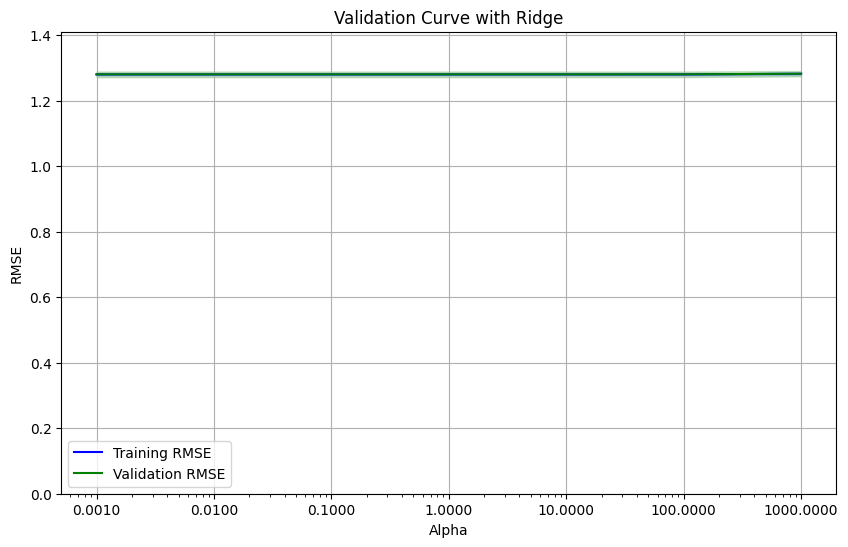

In [6]:
param_range = np.logspace(-3, 3, 7)

train_scores, valid_scores = validation_curve(
    pipeline, X_train, y_train, param_name = "ridge__alpha", param_range = param_range,
    scoring = 'neg_mean_squared_error', n_jobs = -1, cv = folds
)

# Convert negative MSE to RMSE
train_rmse = np.sqrt(-train_scores)
valid_rmse = np.sqrt(-valid_scores)

# Calculate mean and standard deviation of scores for plotting
train_rmse_mean = np.mean(train_rmse, axis=1)
train_rmse_std = np.std(train_rmse, axis=1)
valid_rmse_mean = np.mean(valid_rmse, axis=1)
valid_rmse_std = np.std(valid_rmse, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.title("Validation Curve with Ridge")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.ylim(0, max(train_rmse_mean.max(), valid_rmse_mean.max()) * 1.1)  # Adjust y-limits
plt.xscale("log")
plt.xticks(param_range, labels=[f'{p:.4f}' for p in param_range])  # Formatting ticks

# Plotting training RMSE
plt.plot(param_range, train_rmse_mean, label="Training RMSE", color="blue")
plt.fill_between(param_range, train_rmse_mean - train_rmse_std,
                 train_rmse_mean + train_rmse_std, color="blue", alpha=0.2)

# Plotting validation RMSE
plt.plot(param_range, valid_rmse_mean, label="Validation RMSE", color="green")
plt.fill_between(param_range, valid_rmse_mean - valid_rmse_std,
                 valid_rmse_mean + valid_rmse_std, color="green", alpha=0.2)

plt.legend(loc="best")
plt.grid()
plt.show()

## Evaluating Best Ridge Model

In [7]:
clf.best_params_

{'ridge__alpha': 0.26560877829466867}

In [8]:
ridge_model = clf.best_estimator_

y_train_pred = ridge_model.predict(X_train)
y_val_pred = ridge_model.predict(X_val)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Train R² Score: {train_r2:.4f}")
print(f"Validation R² Score: {val_r2:.4f}")
print(f"Train RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")

Train R² Score: 0.7824
Validation R² Score: 0.7749
Train RMSE: 1.2807800028517577
Validation RMSE: 1.303995115682055


## Predicted vs Actual Values (Train Set)

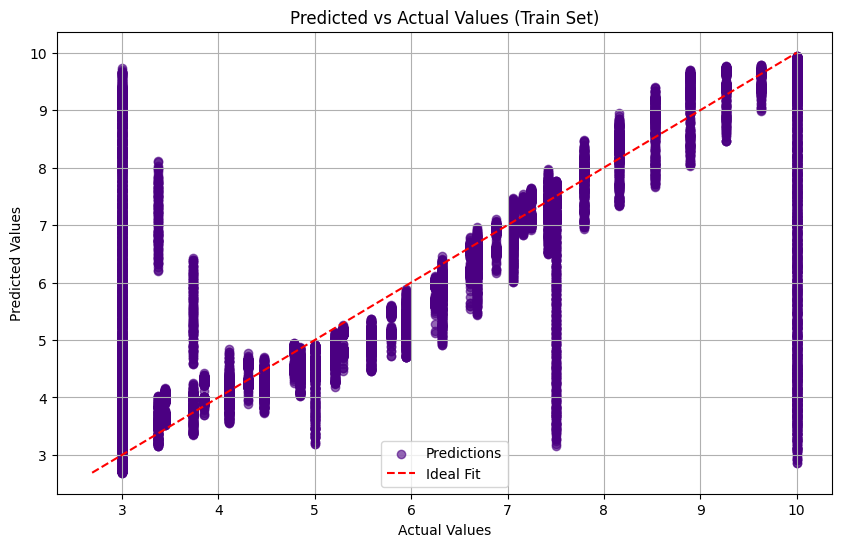

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='indigo', label='Predictions', alpha=0.6)
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Train Set)')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation on Test Data

In [10]:
y_test_pred = ridge_model.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Test R² Score: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse}")

Test R² Score: 0.7927
Test RMSE: 1.2535509945294279


## Predicted vs Actual Values (Test Set)

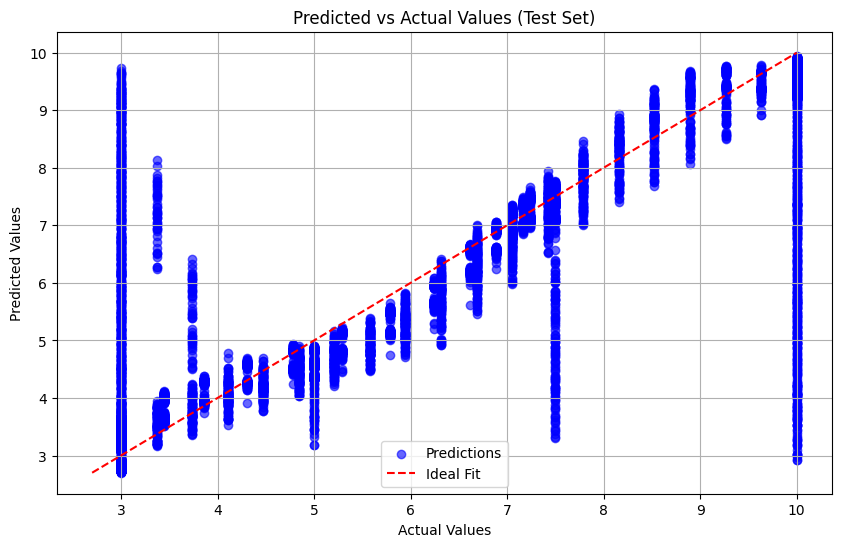

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predictions', alpha=0.6)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()